In [1]:
pip install ChannelAttribution

Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install --upgrade pip

Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None

from ChannelAttribution import *

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
%matplotlib inline

Looking for attribution at path level? Try markov_model_local_api() or ask for ChannelAttributionPro at info@channelattribution.io! Visit https://channelattribution.io for more information.
Version: 2.1.3


## Data
#### This dataset shows digital marketing data that one would typically encounter in a production environment. The data set contains 586,000 marketing touch-points from July (2018), comprising 240,000 unique customers who generated ~18,000 conversions.
#### A more detailed description of the features is shown below:
#### - Cookie: Anonymous customer id enabling us to track the progression of a given customer
#### - Timestamp: Date and time when the visit took place
#### - Interaction: Categorical variable indicating the type of interaction that took place
#### - Conversion: Boolean variable indicating whether a conversion took place
#### - Conversion Value: Value of the potential conversion event (revenue)
#### - Channel: The marketing channel that brought the customer to our site

In [2]:
df = pd.read_csv('attribution data.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 586737 entries, 0 to 586736
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cookie            586737 non-null  object 
 1   time              586737 non-null  object 
 2   interaction       586737 non-null  object 
 3   conversion        586737 non-null  int64  
 4   conversion_value  586737 non-null  float64
 5   channel           586737 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 26.9+ MB


In [4]:
from datetime import datetime
df['time'] = pd.to_datetime(df['time'])

In [5]:
df.head(5)

,cookie,time,interaction,conversion,conversion_value,channel
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search


In [6]:
df.sort_values("time", ascending=True)

,cookie,time,interaction,conversion,conversion_value,channel
457900,iDnfkhBkFBkn33C9fAEkBoA73,2018-07-01 13:13:16+00:00,impression,0,0.0,Facebook
431897,hiB3DAfC33f907hFioEoDhBiA,2018-07-01 13:13:27+00:00,impression,0,0.0,Facebook
531112,nE73noDBofAfn9fFfB7if93hk,2018-07-01 13:13:41+00:00,impression,0,0.0,Facebook
543728,nkE9F9kok73CAoE9DEDDFo7iA,2018-07-01 13:14:05+00:00,impression,0,0.0,Instagram
210164,Bi90AoDAkkD0koDF30CCFiknh,2018-07-01 13:14:42+00:00,impression,0,0.0,Instagram
...,...,...,...,...,...,...
200880,BE0oFnnCi7ACifF9hik9iiCF9,2018-07-31 23:35:51+00:00,impression,0,0.0,Paid Search
42539,37kooEohooffAEfCoDAhih97o,2018-07-31 23:39:52+00:00,impression,0,0.0,Paid Search
152253,A9B3i9hoih7Eki07niEf7Eh77,2018-07-31 23:49:17+00:00,impression,0,0.0,Paid Search
62986,3hnhC0AAAnCfoknAhf0k9hkBC,2018-07-31 23:56:52+00:00,impression,0,0.0,Paid Search


## EDA

In [7]:
#Plotting conversions over time by channel
conversions = df.loc[df['conversion'] == 1]
conversions['time'] = conversions['time'].dt.date
conversions.drop(columns = ['cookie', 'interaction'], inplace = True)
conversions = conversions.groupby(['time','channel'], as_index=False).sum()


In [8]:
conversions

,time,channel,conversion,conversion_value
0,2018-07-01,Facebook,135,835.0
1,2018-07-01,Instagram,69,438.5
2,2018-07-01,Online Display,75,463.5
3,2018-07-01,Online Video,42,257.5
4,2018-07-01,Paid Search,98,590.5
...,...,...,...,...
145,2018-07-30,Online Video,15,91.0
146,2018-07-30,Paid Search,81,509.0
147,2018-07-31,Facebook,100,628.0
148,2018-07-31,Instagram,51,339.5


In [9]:
print(conversions.channel.unique())

['Facebook' 'Instagram' 'Online Display' 'Online Video' 'Paid Search']


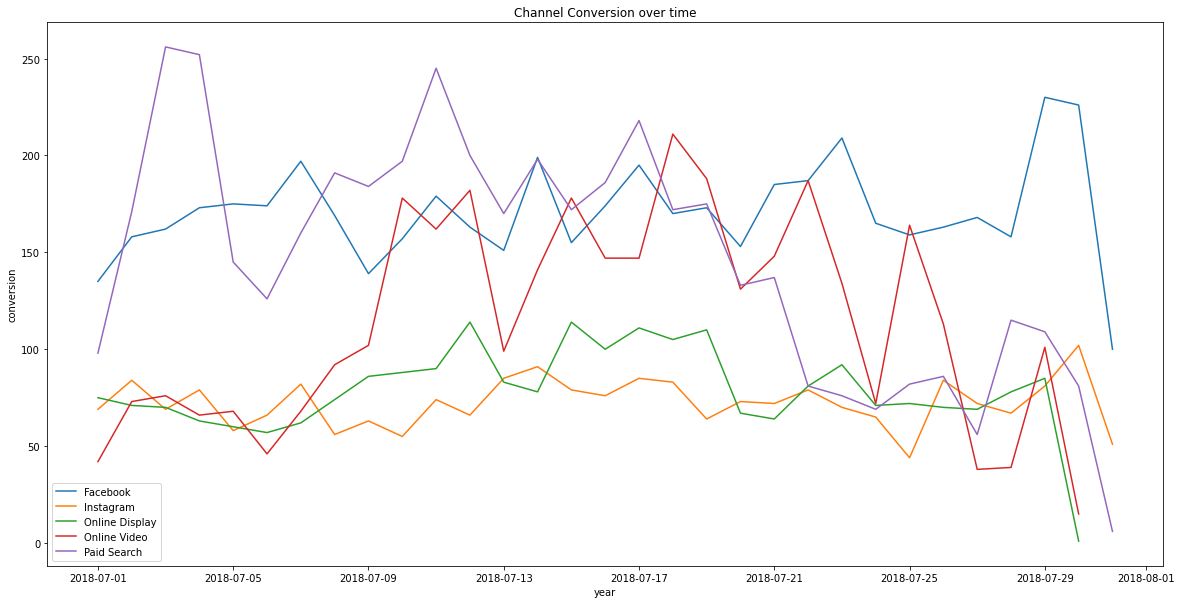

In [10]:
fig,ax = plt.subplots(figsize=(20,10))

for channel in ['Facebook', 'Instagram', 'Online Display', 'Online Video', 'Paid Search']:
    ax.plot(conversions[conversions.channel==channel].time,conversions[conversions.channel==channel].conversion,label=channel)

ax.set_xlabel("year")
ax.set_ylabel("conversion")
ax.set_title('Channel Conversion over time')
ax.legend(loc='best')

## Data Pre-processing

In [11]:
#Creating the path order for when users interact with different channels (this is equivalent to SQL window functions)
df['path_order'] = df.sort_values(['time']).groupby(['cookie']).cumcount() + 1
df

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1
...,...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12 23:50:45+00:00,impression,0,0.0,Online Display,2
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12 23:50:54+00:00,impression,0,0.0,Online Display,3
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03 12:57:25+00:00,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19 08:17:59+00:00,impression,0,0.0,Online Video,2


In [12]:
df

,cookie,time,interaction,conversion,conversion_value,channel,path_order
0,00000FkCnDfDDf0iC97iC703B,2018-07-03 13:02:11+00:00,impression,0,0.0,Instagram,1
1,00000FkCnDfDDf0iC97iC703B,2018-07-17 19:15:07+00:00,impression,0,0.0,Online Display,2
2,00000FkCnDfDDf0iC97iC703B,2018-07-24 15:51:46+00:00,impression,0,0.0,Online Display,3
3,00000FkCnDfDDf0iC97iC703B,2018-07-29 07:44:51+00:00,impression,0,0.0,Online Display,4
4,0000nACkD9nFkBBDECD3ki00E,2018-07-03 09:44:57+00:00,impression,0,0.0,Paid Search,1
...,...,...,...,...,...,...,...
586732,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12 23:50:45+00:00,impression,0,0.0,Online Display,2
586733,ooooEiB0CCoEf9fiiC90Dfhfk,2018-07-12 23:50:54+00:00,impression,0,0.0,Online Display,3
586734,ooooiBh70D3k3BfAhDFfii9h7,2018-07-03 12:57:25+00:00,impression,0,0.0,Paid Search,1
586735,ooooiBh70D3k3BfAhDFfii9h7,2018-07-19 08:17:59+00:00,impression,0,0.0,Online Video,2


In [13]:
#Aggregating the channels a user interacted with into a single row
df_paths = df.groupby('cookie')['channel'].agg(lambda x: x.tolist()).reset_index()
df_paths = df_paths.rename(columns={"channel": "path"})
df_paths.head()

,cookie,path
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On..."
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S..."
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S..."
3,00073CFE3FoFCn70fBhB3kfon,[Instagram]
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search]


In [14]:
#Looking at the last interaction to see if it led to a user converting
df_last_interaction = df.drop_duplicates('cookie', keep='last')[['cookie', 'conversion', 'conversion_value']]
df_last_interaction.head()

,cookie,conversion,conversion_value
3,00000FkCnDfDDf0iC97iC703B,0,0.0
9,0000nACkD9nFkBBDECD3ki00E,0,0.0
14,0003EfE37E93D0BC03iBhBBhF,0,0.0
15,00073CFE3FoFCn70fBhB3kfon,0,0.0
16,00079hhBkDF3k3kDkiFi9EFAD,0,0.0


In [15]:
#Concatinating with the dataframes of user path's
df_paths = pd.merge(df_paths, df_last_interaction, how='left', on='cookie')
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,"[Instagram, Online Display, Online Display, On...",0,0.0
1,0000nACkD9nFkBBDECD3ki00E,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
2,0003EfE37E93D0BC03iBhBBhF,"[Paid Search, Paid Search, Paid Search, Paid S...",0,0.0
3,00073CFE3FoFCn70fBhB3kfon,[Instagram],0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,[Paid Search],0,0.0


In [16]:
print('Total conversions: {}'.format(sum(df.conversion)))
print('Total conversion rate: {}%'.format(round(sum(df.conversion) / len(df)*100)))
print('Total value of conversions: ${}'.format(round(sum(df.conversion_value))))
print('Average conversion value: ${}'.format(round(sum(df.conversion_value) / sum(df.conversion))))

Total conversions: 17639
Total conversion rate: 3%
Total value of conversions: $110231
Average conversion value: $6


In [17]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
def listToString(df):  
    str1 = ""  
    for i in df['path']:  
        str1 += i + ' > '    
    return str1[:-3]

df_paths['path'] = df_paths.apply(listToString, axis=1)
df_paths.head()

,cookie,path,conversion,conversion_value
0,00000FkCnDfDDf0iC97iC703B,Instagram > Online Display > Online Display > ...,0,0.0
1,0000nACkD9nFkBBDECD3ki00E,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
2,0003EfE37E93D0BC03iBhBBhF,Paid Search > Paid Search > Paid Search > Paid...,0,0.0
3,00073CFE3FoFCn70fBhB3kfon,Instagram,0,0.0
4,00079hhBkDF3k3kDkiFi9EFAD,Paid Search,0,0.0


In [18]:
#Removing the user's cookie and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
df_paths.drop(columns = 'cookie', inplace = True)
df_paths['null'] = np.where(df_paths['conversion'] == 0,1,0)

attribution_df = df_paths.groupby(['path'], as_index = False).sum()
attribution_df.rename(columns={"conversion": "total_conversions", "null": "total_null", "conversion_value": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
8675,Online Video > Online Video > Online Video > O...,1,6.0,0
7130,Online Display > Online Display > Paid Search ...,0,0.0,1
2012,Facebook > Facebook > Paid Search > Instagram ...,0,0.0,1
8216,Online Video > Online Video > Online Video > F...,0,0.0,1
3984,Facebook > Paid Search > Paid Search > Paid Se...,0,0.0,1
609,Facebook > Facebook > Facebook > Facebook > In...,1,8.5,0
6106,Instagram > Paid Search > Paid Search > Paid S...,0,0.0,1
8494,Online Video > Online Video > Online Video > O...,0,0.0,1
8984,Online Video > Online Video > Paid Search > On...,0,0.0,1
5850,Instagram > Online Video > Online Video > Onli...,0,0.0,1


In [19]:
df_paths.query("conversion==1")

,path,conversion,conversion_value,null
7,Paid Search,1,6.5,0
8,Facebook,1,8.0,0
34,Facebook,1,6.0,0
36,Online Video > Online Video > Online Video > O...,1,6.5,0
44,Facebook > Facebook,1,7.5,0
...,...,...,...,...
240082,Online Video > Paid Search > Paid Search > Pai...,1,7.0,0
240088,Facebook > Instagram > Online Display > Paid S...,1,6.0,0
240093,Online Display > Online Display,1,7.5,0
240095,Paid Search > Online Video > Online Video > On...,1,6.0,0


In [20]:
#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")

In [22]:
#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")

Number of simulations: 100000 - Convergence reached: 1.58% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (48) is reached: 99.99%


In [25]:
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions","linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

In [26]:
R

,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value,total_conversions,total_conversion_value
0,Facebook,5177.0,32283.0,5301.0,33143.5,5218.903371,32614.300094,5258.017942,32826.061993
1,Instagram,2329.0,14579.5,2244.0,14039.5,2265.179353,14171.723842,3471.060425,21711.207332
2,Online Display,2160.0,13419.0,2139.0,13298.5,2124.315256,13205.187068,2048.049981,12766.400371
3,Online Video,3216.0,20225.5,3408.0,21418.0,3349.403371,21045.330408,2877.668461,18065.749695
4,Paid Search,4757.0,29724.0,4547.0,28331.5,4681.198650,29194.458588,3984.203191,24861.580609


In [27]:
R1

,channel_name,first_touch,last_touch,linear_touch,markov_model
0,Facebook,5177.0,5301.0,5218.903371,5258.017942
1,Instagram,2329.0,2244.0,2265.179353,3471.060425
2,Online Display,2160.0,2139.0,2124.315256,2048.049981
3,Online Video,3216.0,3408.0,3349.403371,2877.668461
4,Paid Search,4757.0,4547.0,4681.198650,3984.203191


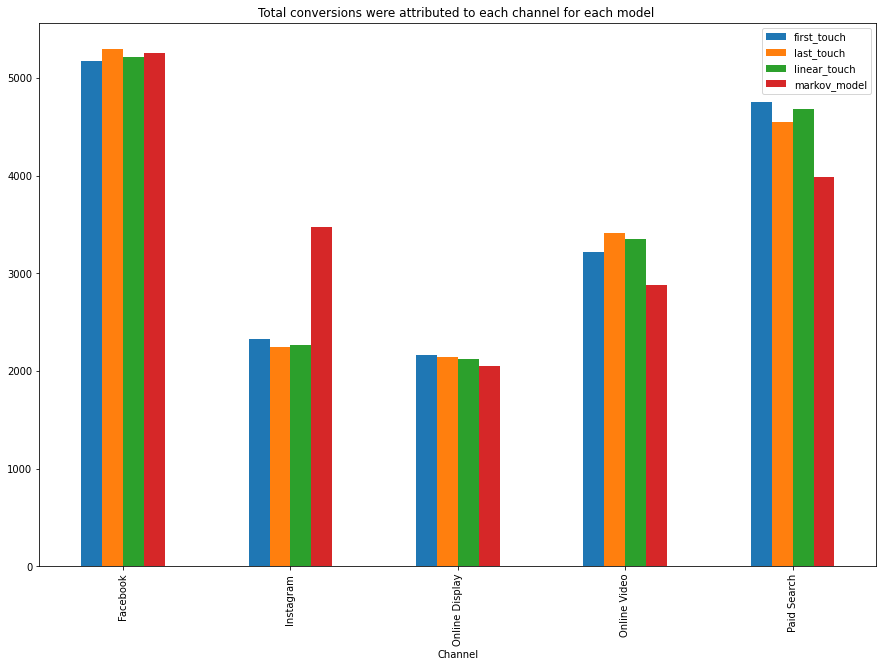

In [28]:
ax7 = R1.plot(x="channel_name", 
              y=["first_touch","last_touch","linear_touch","markov_model"],
              kind="bar", 
              figsize=(15,10))

ax7.set_xlabel('Channel')
ax7.set_title('Total conversions were attributed to each channel for each model ')

plt.show()

- The bar chart above shows how many conversions were attributed to each channel for each model. Analyzing the graph, specifically the markov_model in comparison to the other methods, we can gain insights as to the relative importance of different marketing channels. For the first touch, last touch and linear touch models, Facebook and Paid Search are the most important channels driving conversions while Instagram and Online Display are the least important. However, according to the Markov Model, Instagram is far more important to the conversions than other attribution models suggest 
- Similar to the total conversions bar chart, a revenue bar chart can be created highlighting the revenue attributed to each channel.

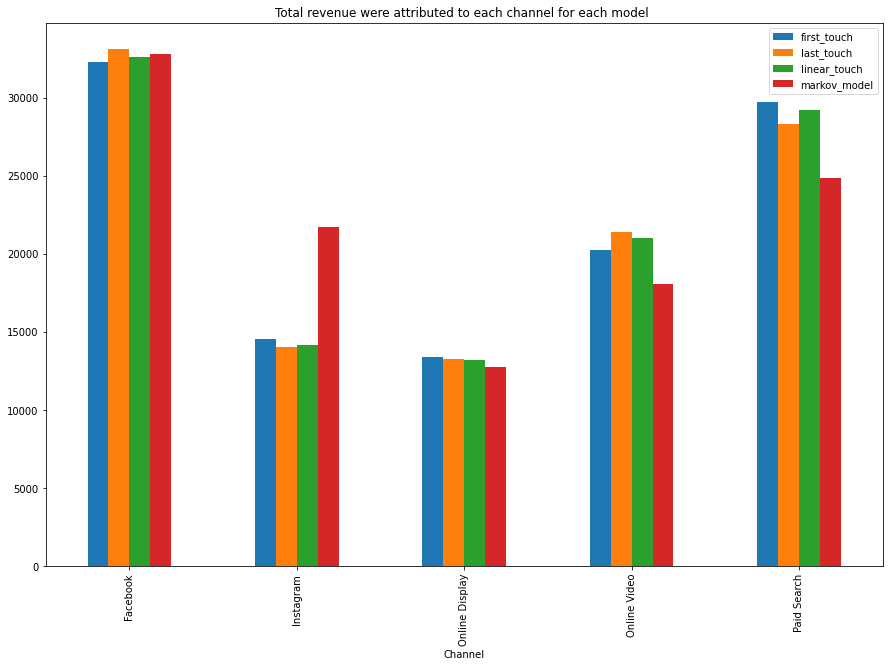

In [29]:
R2=R[["channel_name","first_touch_value","last_touch_value",\
"linear_touch_value","total_conversion_value"]]
R2.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

ax8 = R2.plot(x="channel_name", 
              y=["first_touch","last_touch","linear_touch","markov_model"],
              kind="bar", 
              figsize=(15,10))

ax8.set_xlabel('Channel')
ax8.set_title('Total revenue were attributed to each channel for each model ')

plt.show()

- As expected, the total revenue attributed to each channel corresponds to the number of conversions that it generates.
- To get an idea of how the different channels affect a user's journeys we can also look at the transition probability matrix, which can be visualized in a heatmap.

In [35]:
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

In [38]:
matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5]),
 [Text(0.5, 0, '(conversion)'),
  Text(1.5, 0, '(null)'),
  Text(2.5, 0, 'Facebook'),
  Text(3.5, 0, 'Instagram'),
  Text(4.5, 0, 'Online Display'),
  Text(5.5, 0, 'Online Video'),
  Text(6.5, 0, 'Paid Search')])

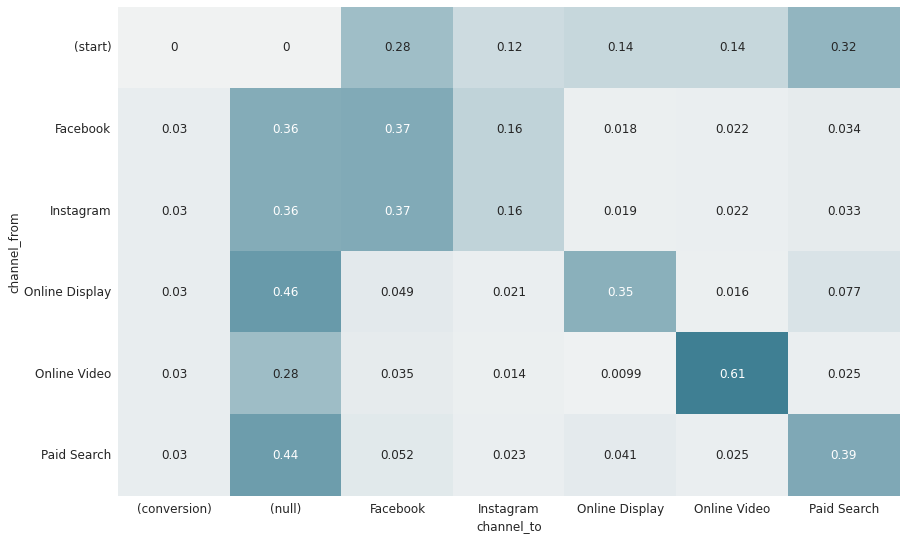

In [39]:
#Heat map for transition probabilities in the data set
fig = plt.figure(figsize = (14,9))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix, cmap=sns.diverging_palette(20, 220, n=200), annot=True, center = 0,\
            annot_kws={'size':12}, cbar=False)
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

# Conclusions
Using the heat map and the plots above we not only gain insights into how each marketing channel is driving conversions, but we also gain critical information around how our channels are interacting with each other, driving users one channel to another. Using the Markov Chain approach outlined in this article will allow your attributions to more accurately reflect how your users are interacting with your marketing.